# Building the dataset

This project will rely heavily in the use of API as data sources. Contrary to most machine learning challenges and competitions, working in the industry usually requires the ML Developer to work with multiple teams and use heterogeneous sources of information to get the necessary data to solve a particular problem. Access to data is often provided through application programming interfaces (APIs), whether internal or external to the organization. It is very important to understand how to interact with APIs to collect data in our day to day work.


### Objetive of this notebook

Create a single pandas dataframe with information about all active players in the 2021/2022 NBA season. 

- Understanding how to query an API to create a dataset with Python and Pandas
- Learning how to cleanup a dataset and generate new fields from calculated data
- Storing the created dataset in a serialized manner
- Generating statistics about the data
- Visualizing data

### The dataset

The dataset is designed to have the following structure:

- Personal Information
    - player_id (int) (INDEX) 
    - player_name (str)
    - team_name (str)
    - position (str)
    - height (int) (in centimeters) 
    - weight (float) (in kilograms)
    - country of origin (str)
    - date_of_birth (datetime)
    - age (str) (years and months)
    - years_of_experience (int) (years since entering the league)
    - Draft position (int)
- Player career statistics
    - games played (int)
    - minutes per game (float)
    - points per game (float)
    - rebounds per game (float)
    - assists per game (float)
    - steals per game (float)
    - blocks per game (float)
- Misc
    - salary in dollars (int) (contract value for this season only)
    - next_game_date (datetime)

## Collecting information for building our dataset

To get the information I relied on the official [NBA API](https://github.com/swar/nba_api).

This is a Python library that can be used to obtain data from [stats.nba.com](stats.nba.com), it provides a set of methods that abstracts you from making the http calls, but directly makes calls to nba stats page and parses the results. [Here](https://github.com/swar/nba_api/blob/master/docs/examples/Basics.ipynb) are a couple of examples on how to use it.
    

A few notes on data collection:

- **Start simple:** Try to get all the required information for 1 player, read the APIs documentation carefuly, then think about how to use them to collect all players data. 

- **Don't be in a hurry:** Please bear in mind that the most public APIs have some kind of rate limit, so you have to be careful about iterating on data and making lots of requests in a short amount of time (a 1 second delay between calls to the api should be enough). Once you've collected what you needed, save it to file in order to retrieve it later without calling the API again.

- **A key consideration:** I only wanted data about players that have played in the current season, so make sure to filter those out before collecting the rest of the information.

- **Other sources data:** There is one piece of information that is not in both of those APIs: *the player contract information*. I used [Basketball reference](https://www.basketball-reference.com/contracts/players.html) because it lets you export the data as a csv.  

1- Create a function to find all ACTIVE players, meaning players that are listed with a team in the 2021/2022 season. For now you only need the player id, name, and team. Save the dataframe to a csv named "nba_current_players_list.csv". The function should return the dataframe.

In [8]:
!pip install nba_api
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import playerprofilev2
from nba_api.stats.endpoints import commonallplayers
import pandas as pd
import numpy as np
from time import sleep
from unidecode import unidecode
from datetime import datetime, date
from dateutil import relativedelta

In [10]:
def get_and_save_players_list():
  """
  This function will return all active NBA players from season 2021-22 as a 
  Pandas dataframe with the columns : ['PLAYER ID', 'PLAYER NAME', 'TEAM NAME']
  """
  # handling exception of calling to NBA API
  try:
    # getting all active players by the current season by an API call
    players = commonallplayers.CommonAllPlayers(season="2021-22")
  except Exception as trouble:
    print(f'Exception raised with error:{trouble}')
  # getting a dataframe from the object
  players_df = players.get_data_frames()[0] 

  #mask to remove All players with TEAM_ID == 0
  mask_team= players_df['TEAM_ID'] != 0
  #mask to remove All players with GAMES_PLAYED_FLAG == N
  mask_games_played_flag= players_df["GAMES_PLAYED_FLAG"] != 'N'
  #mask to remove Player with id 1630597
  mask_player= players_df['PERSON_ID'] != 1630597
  #aplly mask to dataframe
  players_df = players_df[mask_team & mask_games_played_flag & mask_player]

  #filtering the columns to fit the output
  players_df = players_df[["PERSON_ID", "DISPLAY_FIRST_LAST", "TEAM_NAME"]]
  #rename the columns to fit the required output
  players_df.rename(columns = {'PERSON_ID':'PLAYER_ID', 'DISPLAY_FIRST_LAST':'PLAYER_NAME'}, inplace = True)
  #set column Player_id as the dataframe index 
  players_df = players_df.set_index('PLAYER_ID')

  return players_df

In [11]:
current_players_list = get_and_save_players_list()
current_players_list.to_csv("nba_current_players_list.csv")

2- Create a function to find the personal information of all players listed in the dataframe created in the previous step, and save it to a csv file named "nba_players_personal_info.csv". The function should also return the created dataframe.

In [12]:
def get_players_personal_information(current_players_list):
  """
  This function will return personal information by each PLAYER_ID 
  in current_players_list as a Pandas dataframe adding the columns : 
  ['PLAYER ID','PLAYER_NAME','TEAM_NAME','POSITION','HEIGHT',
  'WEIGHT','COUNTRY','BIRTHDATE','SEASON_EXP','DRAFT_NUMBER']
  """
  # creating empty DataFrame
  players_personal_df = pd.DataFrame([])
  #looping on DataFrame by index ["PLAYER_ID"]
  for player in current_players_list.index:
    # handling exception of calling to NBA API
    try:
      # get player info by an API call
      player_info = commonplayerinfo.CommonPlayerInfo(player)
      #avoiding timeout with sleep
      sleep(0.5)
    except Exception as trouble:
      print(f'Exception raised with error:{trouble}')
      continue
    # getting a DataFrame from the object
    personal_info = player_info.get_data_frames()[0]
    # filtering the Dataframe columns to fit the output
    personal_info = personal_info [['PERSON_ID','DISPLAY_FIRST_LAST','TEAM_NAME','POSITION','HEIGHT','WEIGHT','COUNTRY','BIRTHDATE','SEASON_EXP','DRAFT_NUMBER']]
    # rename the column to fit the output
    personal_info.rename(columns = {'PERSON_ID':'PLAYER_ID','DISPLAY_FIRST_LAST':'PLAYER_NAME'},inplace=True)  
    # concatenate empty Dataframe with each value gathered in personal_info
    players_personal_df = pd.concat([players_personal_df,personal_info])
  #set column Player_id as the dataframe index 
  players_personal_df = players_personal_df.set_index('PLAYER_ID')

  return(players_personal_df)



In [13]:
players_personal_info = get_players_personal_information(current_players_list)
players_personal_info.to_csv("nba_players_personal_info.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


3- Create a function to find players career statistics, store the information in a CSV file called "nba_players_career_stats.csv"

In [14]:
def get_players_career_stats(current_players_list):
  """
  This function will return the total career information by each PLAYER_ID in 
  current_players_list as a Pandas dataframe with the columns : 
  ['PLAYER ID','PLAYER_ID','GP','MIN','PTS','REB','AST','STL','BLK']
  """
  # creating an empty DataFrame
  players_careerstats_df = pd.DataFrame([])
  
  #looping on DataFrame by index ["PLAYER_ID"]
  for player in current_players_list.index:
    #handling exception 
    try:
      #call to NBA API endpoint
      player_career = playercareerstats.PlayerCareerStats(player_id= player ,per_mode36='PerGame').get_normalized_dict()['CareerTotalsRegularSeason'][0]
      # avoiding API read timeout with sleep
      sleep(0.5)
    except Exception as trouble:
      print(f'Exception raised with: {player} with error:{trouble}')
    # getting a DataFrame from the dictionary
    players_career_df = pd.DataFrame([player_career], columns= player_career.keys())
    # filtering the Dataframe columns to fit the output
    players_career_df = players_career_df[['PLAYER_ID','GP','MIN','PTS','REB','AST','STL','BLK']]
    # concatenate empty Dataframe created at first
    players_careerstats_df = pd.concat([players_careerstats_df,players_career_df])
  #set column Player_id as the dataframe index 
  players_careerstats_df = players_careerstats_df.set_index('PLAYER_ID')

  return(players_careerstats_df)

In [15]:
players_career_stats = get_players_career_stats(current_players_list)
players_career_stats.to_csv("nba_players_career_stats.csv")

Exception raised with: 1630492 with error:list index out of range


4- Create a function to find players next games and save the information to a csv call "nba_players_next_game.csv"

In [16]:
def get_players_next_game(current_players_list):
  """
  This function will return the player's next game information by each PLAYER_ID 
  in current_players_list as a Pandas dataframe with the columns : 
  ['PLAYER ID','GAME_DATE']
  """
  # creating an empty DataFrame
  player_nextgame_df = pd.DataFrame([])

  #looping on DataFrame by index ["PLAYER_ID"]
  for player in current_players_list.index:
    #handling exception 
    try:
      #call to NBA API endpoint
      #player_game = playerprofilev2.PlayerProfileV2(player).get_normalized_dict()['NextGame'][0]
      player_game = playerprofilev2.PlayerProfileV2(player)
      #avoiding timeout with sleep
      sleep(0.5)
    except Exception as trouble:
      print(f'Exception raised with: {player} with error:{trouble}')  
    
    #getting a dictionary from endpoint
    nextgame_df = player_game.next_game.get_dict()
    # getting a DataFrame from the dictionary
    nextgame_df = pd.DataFrame(data=nextgame_df['data'], columns= nextgame_df['headers'])
    #nextgame_df = pd.DataFrame([player_game], columns= player_game.keys())
    # adding the column PLAYER_ID to the new DataFrame
    nextgame_df['PLAYER_ID'] = player
    # filtering the Dataframe columns to fit the output
    nextgame_df = nextgame_df[['PLAYER_ID','GAME_DATE']]
    # concatenate empty Dataframe with each value gathered in personal_info
    player_nextgame_df = pd.concat([player_nextgame_df,nextgame_df])
  #set column PLAYER_ID as the dataframe index 
  player_nextgame_df = player_nextgame_df.set_index('PLAYER_ID')
  
  return(player_nextgame_df)

In [17]:
players_next_game = get_players_next_game(current_players_list)
players_next_game.to_csv("nba_players_next_game.csv")

5- Create a function to find players salary for this season, save the information to a csv called "nba_players_salary.csv". Make sure the players names format match the ones in the API, otherwise you won't be able to merge the data later.

Hint: Using data from the Basketball Reference page, you will have to solve 2 kinds of problems, duplicated values (for which you should keep just the first value) and players names not matching with the ones from the API. The latter problem has multiple causes, one of them is that some names are written with non ascii characters (there are libraries for dealing with that).

In [30]:
#gather external salaries data as a dataframe
salaries_df= pd.read_html('https://www.basketball-reference.com/contracts/players.html')[0]
#drop level to delete an extra index column
salaries_df = salaries_df.droplevel(0,axis=1)
#select the columns to use 
salaries_df = salaries_df[['Player','2022-23']]
#save the dataframe into a csv
salaries_df.to_csv('nba_players_salaries_baskref.csv',index=False)


def get_nba_players_salaries(csv_file_path):    
  """
  This function will return the player's next game information by each PLAYER_ID 
  in current_players_list as a Pandas dataframe with the columns : 
  ['PLAYER ID','GAME_DATE']
  """
  #read csv with salaries info
  salaries_df = pd.read_csv('https://raw.githubusercontent.com/agusle/nba-players-predictions/main/data/nba_players_salaries_baskref.csv')
  #rename the first column to fit required output
  salaries_df.rename(columns={"Player" : "PLAYER_NAME"}, inplace=True)

  #data cleaning for null values and duplicates
  salaries_df = salaries_df[salaries_df['PLAYER_NAME'].notna()]
  salaries_df = salaries_df[salaries_df['2022-23'].notna()] 
  salaries_df = salaries_df[salaries_df['PLAYER_NAME']!= 'Player']
  salaries_df = salaries_df.drop_duplicates()

  #applying unidecode to remove non ascii characters and removing spaces 
  salaries_df['PLAYER_NAME']= salaries_df['PLAYER_NAME'].apply(lambda s: unidecode(s)).str.strip()

  #removing spaces in PLAYER_NAME
  current_players_list['PLAYER_NAME'] = current_players_list ['PLAYER_NAME'].str.strip() 
  #reset index to work with PLAYER_ID
  current_players_list.reset_index(inplace=True)
  
  #merge dataframes
  salaries_merge_df = pd.merge(current_players_list,salaries_df, on='PLAYER_NAME',how='left')

  #filtering and renaming the columns
  salaries_merge_df = salaries_merge_df[['PLAYER_ID','2022-23']]
  salaries_merge_df.rename(columns = {'2022-23':'SALARY'}, inplace = True)
  
  #set column Player_id as the dataframe index 
  salaries_merge_df = salaries_merge_df.set_index('PLAYER_ID')
  
  return salaries_merge_df

In [31]:
players_salaries = get_nba_players_salaries("contracts.csv")
players_salaries.to_csv("nba_players_salary.csv")

6- Create a function to merge the created dataframes: players_personal_info, players_career_stats, players_next_game, players_salaries. For each dataframe, select only the subset of columns needed to create the dataset described in section "The Dataset"

    - Players info: "PLAYER_NAME", "TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER"
    - Players stats: "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK"
    - Misc: "GAME_DATE", "SALARY"

Save the result to a csv called "raw_nba_players_dataset.csv"

Hint: Before merging the data, you should make sure all four dataframes have the same length, are indexed by PERSON_ID and have the same keys

In [32]:
def merge_dataframes(players_personal_info, players_career_stats, players_next_game, players_salaries):
  """
  This function will merge four dataframes input based on 'PLAYER_ID' column.
  The type of merge is on left: use only keys from first frame, preserve key order.  
  """
  #merge dataframes
  raw_df = pd.merge(players_personal_info,players_career_stats, on='PLAYER_ID',how='left')
  raw_df = pd.merge(raw_df,players_next_game, on='PLAYER_ID',how='left')
  raw_df = pd.merge(raw_df,players_salaries, on='PLAYER_ID',how='left')

  return raw_df

In [33]:
raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_next_game, players_salaries)
raw_players_dataset.to_csv("raw_nba_players_dataset.csv")

## Data Cleaning and Preprocessing

There are several steps that you will have to follow, depending on where you have collected the data some information might be missing.  

- Height and weight might need to be converted to the metric system
- Players that have no team assigned should be removed from the dataset
- Players with no contracts (meaning they don't have a salary defined) should be removed from the dataset
- If the "position" data is ambiguous (listed at multiple positions), use the first value
- If the player does not have height or weight data, use the average for its position as its value
- In order to fill the column next_game_date, just consider the date of the next game of each player's team. 

1- Create a copy of your dataset named "working_df", remove all players with no teams or salary

In [34]:
def copy_and_delete_nan(players_dataset):
  """
  This function copy the dataframe and delete NaN in TEAM_NAME' and 'SALARY' columns
  """
  working_df = players_dataset.copy()
  working_df.dropna(subset=['TEAM_NAME', 'SALARY'],inplace=True)
  return working_df
    

In [35]:
working_df = copy_and_delete_nan(raw_players_dataset)

*2*- Cast Salary, Birthday and Game Date columns to its corresponding type (int, datetime) 

In [36]:
### Complete in this cell: cast all columns to its type
def cast_columns(working_df):
  """
  This function cast the following columns of the dataframe input as argument:
  'SALARY' to integer
  'BIRTHDATE' to datetime in format "%Y-%m-%d"
  'GAME_DATE' to integer in format "%Y-%m-%d"
  """
  working_df["SALARY"] = working_df["SALARY"].replace("[$,]", "", regex=True).astype(int)
  working_df['BIRTHDATE'] = pd.to_datetime(working_df['BIRTHDATE'],format= "%Y-%m-%d")
  working_df['GAME_DATE'] = pd.to_datetime(working_df['GAME_DATE'])

  return working_df

In [37]:
cast_columns(working_df)

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,SALARY
PLAYER_ID,,,,,,,,,,,,,,,,,,
1630173,Precious Achiuwa,Raptors,Forward,6-8,225,Nigeria,1999-09-19,2,20,134.0,18.4,7.2,5.1,0.8,0.4,0.5,2022-10-02,2840160
203500,Steven Adams,Grizzlies,Center,6-11,265,New Zealand,1993-07-20,9,12,664.0,26.8,9.3,8.0,1.5,0.9,0.9,2022-10-01,17926829
1628389,Bam Adebayo,Heat,Center-Forward,6-9,255,USA,1997-07-18,5,14,343.0,28.2,13.5,8.3,3.5,1.0,0.9,2022-10-04,30351780
1630583,Santi Aldama,Grizzlies,Forward-Center,6-11,215,Spain,2001-01-10,1,30,32.0,11.2,4.1,2.7,0.7,0.2,0.3,2022-10-01,2094120
1629638,Nickeil Alexander-Walker,Jazz,Guard,6-5,205,Canada,1998-09-02,3,17,158.0,19.4,9.3,2.6,2.2,0.7,0.3,2022-10-02,5009633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630593,McKinley Wright IV,Mavericks,Guard,5-11,192,USA,1998-10-25,1,Undrafted,5.0,3.8,1.0,0.0,0.6,0.0,0.0,2022-10-05,1637966
201152,Thaddeus Young,Raptors,Forward,6-8,235,USA,1988-06-21,15,12,1085.0,29.3,12.8,5.8,1.8,1.4,0.4,2022-10-02,8000000
1629027,Trae Young,Hawks,Guard,6-1,164,USA,1998-09-19,4,5,280.0,33.6,25.3,3.9,9.1,0.9,0.2,2022-10-06,37096500


3- Create a function that converts the height column from height in feet and inches to centimeters

In [38]:
def convert_height_column(working_df):
  """
  This function converts the column and 'HEIGHT' of the dataframe from
  feet and inches to centimeters and gives a format as integer
  """
  #split HEIGHT in feet and inches and turn to cm each
  feet = working_df['HEIGHT'].str.split("-").str[0].astype(float) * 30.48
  inches = working_df['HEIGHT'].str.split("-").str[1].astype(float) *2.54
  #sum both measures in column HEIGHT of Dataframe
  working_df['HEIGHT'] = feet + inches
  #turn height dtype to int to fit output
  working_df['HEIGHT'] = working_df['HEIGHT'].astype(int)
  return working_df


In [39]:
convert_height_column(working_df)

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,SALARY
PLAYER_ID,,,,,,,,,,,,,,,,,,
1630173,Precious Achiuwa,Raptors,Forward,203,225,Nigeria,1999-09-19,2,20,134.0,18.4,7.2,5.1,0.8,0.4,0.5,2022-10-02,2840160
203500,Steven Adams,Grizzlies,Center,210,265,New Zealand,1993-07-20,9,12,664.0,26.8,9.3,8.0,1.5,0.9,0.9,2022-10-01,17926829
1628389,Bam Adebayo,Heat,Center-Forward,205,255,USA,1997-07-18,5,14,343.0,28.2,13.5,8.3,3.5,1.0,0.9,2022-10-04,30351780
1630583,Santi Aldama,Grizzlies,Forward-Center,210,215,Spain,2001-01-10,1,30,32.0,11.2,4.1,2.7,0.7,0.2,0.3,2022-10-01,2094120
1629638,Nickeil Alexander-Walker,Jazz,Guard,195,205,Canada,1998-09-02,3,17,158.0,19.4,9.3,2.6,2.2,0.7,0.3,2022-10-02,5009633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630593,McKinley Wright IV,Mavericks,Guard,180,192,USA,1998-10-25,1,Undrafted,5.0,3.8,1.0,0.0,0.6,0.0,0.0,2022-10-05,1637966
201152,Thaddeus Young,Raptors,Forward,203,235,USA,1988-06-21,15,12,1085.0,29.3,12.8,5.8,1.8,1.4,0.4,2022-10-02,8000000
1629027,Trae Young,Hawks,Guard,185,164,USA,1998-09-19,4,5,280.0,33.6,25.3,3.9,9.1,0.9,0.2,2022-10-06,37096500


4- Create a function that converts the weight column from pounds to kilograms

In [40]:
### Complete in this cell: convert weight column
def convert_weight_column(working_df):
  """
  This function converts the column and 'WEIGHT' of the dataframe inserted
  as argument from pounds to kilograms and gives a format as integer
  """
  #equivalence pounds to kilograms
  working_df['WEIGHT'] = working_df['WEIGHT'].astype(int)*0.453592
  #turn WEIGHT dtype to int to fit output
  working_df['WEIGHT'] = working_df['WEIGHT'].astype(int)
  return working_df
    

In [41]:
convert_weight_column(working_df)

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,SALARY
PLAYER_ID,,,,,,,,,,,,,,,,,,
1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134.0,18.4,7.2,5.1,0.8,0.4,0.5,2022-10-02,2840160
203500,Steven Adams,Grizzlies,Center,210,120,New Zealand,1993-07-20,9,12,664.0,26.8,9.3,8.0,1.5,0.9,0.9,2022-10-01,17926829
1628389,Bam Adebayo,Heat,Center-Forward,205,115,USA,1997-07-18,5,14,343.0,28.2,13.5,8.3,3.5,1.0,0.9,2022-10-04,30351780
1630583,Santi Aldama,Grizzlies,Forward-Center,210,97,Spain,2001-01-10,1,30,32.0,11.2,4.1,2.7,0.7,0.2,0.3,2022-10-01,2094120
1629638,Nickeil Alexander-Walker,Jazz,Guard,195,92,Canada,1998-09-02,3,17,158.0,19.4,9.3,2.6,2.2,0.7,0.3,2022-10-02,5009633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630593,McKinley Wright IV,Mavericks,Guard,180,87,USA,1998-10-25,1,Undrafted,5.0,3.8,1.0,0.0,0.6,0.0,0.0,2022-10-05,1637966
201152,Thaddeus Young,Raptors,Forward,203,106,USA,1988-06-21,15,12,1085.0,29.3,12.8,5.8,1.8,1.4,0.4,2022-10-02,8000000
1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,4,5,280.0,33.6,25.3,3.9,9.1,0.9,0.2,2022-10-06,37096500




```
# This is formatted as code
```

5- Create a function that calculates the age in (years, months, days) and saves it in a new string column, example: "22 years, 5 months, 25 days" 

In [42]:
def get_age (birthday):
  """
  This function will return the age in format:
  {years} years, {months} months, {days} days
  """
  #getting today's date
  today = datetime.today()
  #relativedelta function to bring two dates difference
  age = relativedelta.relativedelta(today,birthday)
  return f'{age.years} years, {age.months} months, {age.days} days'

def add_age_column(working_df):
  """
  This function will apply get_age function
  to a dataframe series.
  """
  working_df['AGE'] = working_df['BIRTHDATE'].apply(get_age)

In [43]:
add_age_column(working_df)

6- Create a function that takes care of the disambiguation of the "POSITION" column. Should replace all positions that are mixed with the first one listed.

In [44]:
def update_position(working_df):
  """
  This function replace all positions that are mixed with the first
  one listed. E. g. CENTER - FORWARD the result will be CENTER
  """
  working_df['POSITION']= working_df['POSITION'].str.split("-").str[0]
  return working_df

In [45]:
update_position(working_df)

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,SALARY,AGE
PLAYER_ID,,,,,,,,,,,,,,,,,,,
1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134.0,18.4,7.2,5.1,0.8,0.4,0.5,2022-10-02,2840160,"22 years, 11 months, 12 days"
203500,Steven Adams,Grizzlies,Center,210,120,New Zealand,1993-07-20,9,12,664.0,26.8,9.3,8.0,1.5,0.9,0.9,2022-10-01,17926829,"29 years, 1 months, 11 days"
1628389,Bam Adebayo,Heat,Center,205,115,USA,1997-07-18,5,14,343.0,28.2,13.5,8.3,3.5,1.0,0.9,2022-10-04,30351780,"25 years, 1 months, 13 days"
1630583,Santi Aldama,Grizzlies,Forward,210,97,Spain,2001-01-10,1,30,32.0,11.2,4.1,2.7,0.7,0.2,0.3,2022-10-01,2094120,"21 years, 7 months, 21 days"
1629638,Nickeil Alexander-Walker,Jazz,Guard,195,92,Canada,1998-09-02,3,17,158.0,19.4,9.3,2.6,2.2,0.7,0.3,2022-10-02,5009633,"23 years, 11 months, 29 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630593,McKinley Wright IV,Mavericks,Guard,180,87,USA,1998-10-25,1,Undrafted,5.0,3.8,1.0,0.0,0.6,0.0,0.0,2022-10-05,1637966,"23 years, 10 months, 6 days"
201152,Thaddeus Young,Raptors,Forward,203,106,USA,1988-06-21,15,12,1085.0,29.3,12.8,5.8,1.8,1.4,0.4,2022-10-02,8000000,"34 years, 2 months, 10 days"
1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,4,5,280.0,33.6,25.3,3.9,9.1,0.9,0.2,2022-10-06,37096500,"23 years, 11 months, 12 days"


7- Review that the working dataset has all requested columns with its corresponding datatypes and save it as a csv with name "nba_players_processed_dataset.csv"

In [46]:
#replace Undrafted by NaN values
working_df['DRAFT_NUMBER']= working_df["DRAFT_NUMBER"].replace("Undrafted", np.nan)
#replace NaN values by 0
working_df['DRAFT_NUMBER']= working_df["DRAFT_NUMBER"].fillna(0)
#convert draf_number column into int
working_df['DRAFT_NUMBER'] = working_df['DRAFT_NUMBER'].astype(int)

working_df.to_csv("nba_players_processed_dataset.csv")

## Analyzing and Visualizing data

Now that we have the data, let's do some work

1- Calculate and print the following metrics:

    - General metrics:
        - Total number of players
        - Number of USA born players
        - Number of foreign players
        - Number of players per position
        - Number of players per team
        - Number of rookies (first year players)
    - Players description
        - Average player age (in years)
        - Youngest player age (years and days, i.e: 18 years and 16 days)
        - Oldest player age (years and days, i.e: 40 years and 160 days)
        - Min and Max players height
        - Average height of players per position
    - Contracts
        - Min and Max salary of all players
        - Mean and Median salary of all players

Bonus: if you can, calculate how many players retired between the end of the 2020-2021 season and the start of the 2021-22 season.

In [47]:
#set new index to work with plots
working_df.reset_index(level=0, inplace=True)

In [48]:
### Complete in this cell: print general metrics
total_players_count = len(working_df.index)
usa_players_count = working_df['COUNTRY'][working_df['COUNTRY']== 'USA'].count()
foreign_players_count = working_df['COUNTRY'][working_df['COUNTRY']!= 'USA'].count()
position_count = working_df['POSITION'].value_counts()
#position_count = working_df.groupby('POSITION').count()
team_count = working_df['TEAM_NAME'].value_counts()
#position_count = working_df.groupby('TEAM').count()
rookie_players_count = working_df['SEASON_EXP'][working_df['SEASON_EXP']== 0].count()

print('- General metrics:\n\n', 
    '- Total number of players: ',total_players_count,' players\n'
    '- Number of USA born players: ', usa_players_count,' players\n'
    '- Number of foreign players: ', foreign_players_count,' players\n\n'
    '- Number of players per position: \n', position_count,'\n','\n',
    '- Number of players per team: \n', team_count,'\n','\n'
    '- Number of rookies (first year players): ', rookie_players_count,sep="")

- General metrics:

- Total number of players: 403 players
- Number of USA born players: 302 players
- Number of foreign players: 101 players

- Number of players per position: 
Guard      190
Forward    158
Center      55
Name: POSITION, dtype: int64

- Number of players per team: 
Raptors          16
76ers            16
Rockets          16
Bucks            15
Wizards          14
Mavericks        14
Thunder          14
Grizzlies        14
Celtics          14
Suns             14
Pistons          14
Magic            14
Timberwolves     14
Pelicans         14
Cavaliers        14
Lakers           13
Bulls            13
Knicks           13
Spurs            13
Clippers         13
Jazz             13
Nuggets          13
Trail Blazers    13
Nets             12
Warriors         12
Pacers           12
Hornets          12
Heat             12
Hawks            11
Kings            11
Name: TEAM_NAME, dtype: int64

- Number of rookies (first year players): 0


In [49]:
### Complete in this cell: print players descriptions
from datetime import datetime, date
from dateutil import relativedelta

def get_age_2 (birthdate):
  """
  This function will return the difference between a DOB(date of birth)
  and the current day in Years and days as a list [years, days] 
  """
  #calculate today's date
  today = datetime.today()
  #calculate the age in years
  age_years= relativedelta.relativedelta(today,birthdate).years
  #calculate the days in current age
  age_days= today - (birthdate + relativedelta.relativedelta(years=age_years))
  age = [age_years,age_days.days]
  return age

#apply function to dataframe creating new columns from BIRTHDATE
working_df['AGE_YEARS'] = working_df['BIRTHDATE'].apply(lambda s: get_age_2(s)[0])
working_df['AGE_DAYS'] = working_df['BIRTHDATE'].apply(lambda s: get_age_2(s)[1])

#calculate max and min years
max_years = working_df['AGE_YEARS'].max()
min_years = working_df['AGE_YEARS'].min()

#calculate max and min days
max_days = working_df[working_df['AGE_YEARS'] == working_df['AGE_YEARS'].max()]['AGE_DAYS'].max()
min_days = working_df[working_df['AGE_YEARS'] == working_df['AGE_YEARS'].min()]['AGE_DAYS'].min()

#average of age in years
average_player_age = round(working_df['AGE_YEARS'].mean(),0)
player_height_min = working_df['HEIGHT'].min()
player_height_max = working_df['HEIGHT'].max()
average_heigh_position= working_df.groupby('POSITION')['HEIGHT'].mean().round(2)

print('- Players description:\n\n', 
    '- Average player age (in years): ', average_player_age,' years\n'
    '- Youngest player age: ', min_years,' years, ',min_days,' days','\n'
    '- Oldest player age: ', max_years,' years, ',max_days,' days','\n\n'
    '- Min and Max players height:\n',"     Min: ",player_height_min,"cm"," Max: ", player_height_max,"cm",'\n\n',
    '- Average height of players per position:\n', average_heigh_position,sep="")

- Players description:

- Average player age (in years): 26.0 years
- Youngest player age: 19 years, 250 days
- Oldest player age: 37 years, 244 days

- Min and Max players height:
     Min: 180cm Max: 220cm

- Average height of players per position:
POSITION
Center     210.44
Forward    202.66
Guard      191.94
Name: HEIGHT, dtype: float64


In [50]:
### Complete in this cell: Contracts
player_salary_min = working_df['SALARY'].min()
player_salary_max = working_df['SALARY'].max()
player_salary_mean = round(working_df['SALARY'].mean(),2)
player_salary_median = working_df['SALARY'].median()

print(f'Min salary of all players: U$S {player_salary_min:,}')
print(f'Max salary of all players: U$S {player_salary_max:,}')
print(f'Mean salary of all players: U$S {player_salary_mean:,}')
print(f'Median salary of all players: U$S {player_salary_median:,}')

Min salary of all players: U$S 50,000
Max salary of all players: U$S 48,070,014
Mean salary of all players: U$S 10,381,511.54
Median salary of all players: U$S 5,837,760.0


2- Plot the relationship between scoring (points per game) and salary of all players, the players positions should also be visible.

Text(26.01890914351852, 0.5, 'Salary (MM)')

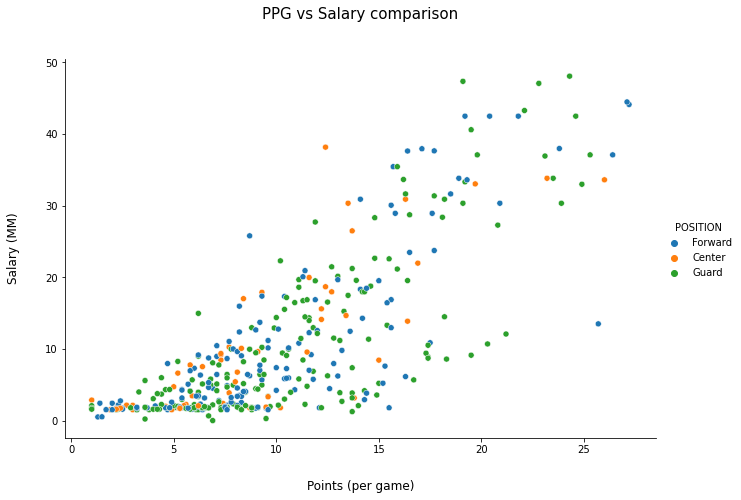

In [51]:
### Complete in this cell:  Relationship between scoring and salary (in millions of dollars)
import seaborn as sns
import matplotlib.pyplot as plt

#calculate salary in Millions
player_salary_millions =  working_df['SALARY']/1000000

#create the plot
ppg_sal = sns.relplot(data=working_df, x="PTS", y=player_salary_millions,hue='POSITION',height=6, aspect=1.5)

#set plot title and axis labels
plt.title("PPG vs Salary comparison", fontsize=15,pad=40)
plt.xlabel('Points (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)


3- Now plot assists-vs-salary and rebounding-vs-salary

Text(26.01890914351852, 0.5, 'Salary (MM)')

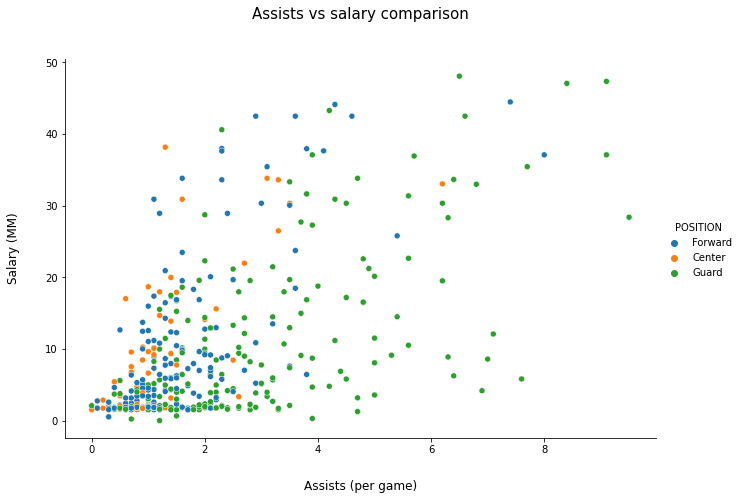

In [52]:
### Complete in this cell: plot assist-vs-salary, rebounding-vs-salary

#create the plot
ast_sal = sns.relplot(data=working_df, x="AST", y=player_salary_millions,hue='POSITION',height=6, aspect=1.5)

#set plot title and axis labels
plt.title("Assists vs salary comparison", fontsize=15,pad=40)
plt.xlabel('Assists (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)


Text(26.01890914351852, 0.5, 'Salary (MM)')

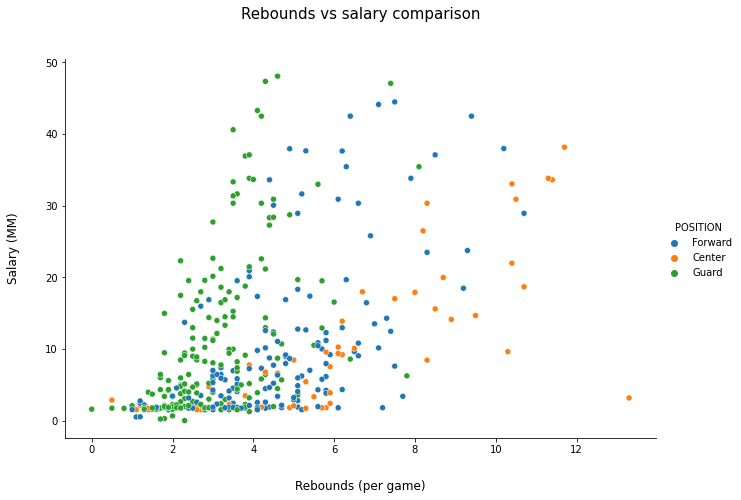

In [53]:
#create the plot
reb_sal = sns.relplot(data=working_df, x="REB", y=player_salary_millions,hue='POSITION',height=6, aspect=1.5)

#set plot title and axis labels
plt.title("Rebounds vs salary comparison", fontsize=15,pad=40)
plt.xlabel('Rebounds (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)

4- When NBA players enter the league, they have low value salaries during what is called their "rookie contract". This means that it doesn't matter how well the player performs, they can't have large salaries. This can distort our understanding of how much teams value each skill, as a player could score 50 points a game and still earn just a couple of millions. So, lets now plot points, assists and rebounding vs salary, but only for players that have more than 4 years of experience (the typical length of a rookie contract)

Text(28.872421874999993, 0.5, 'Salary (MM)')

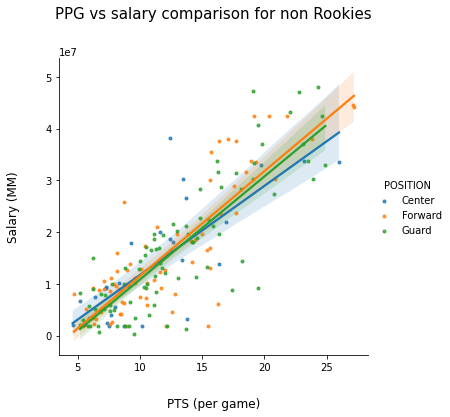

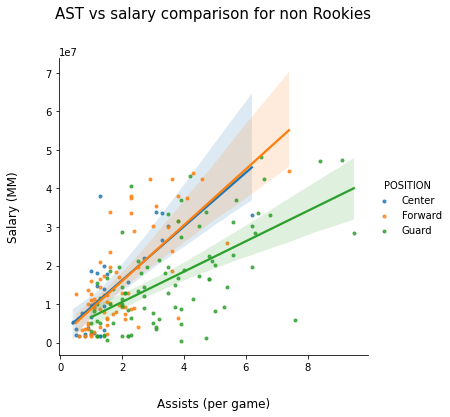

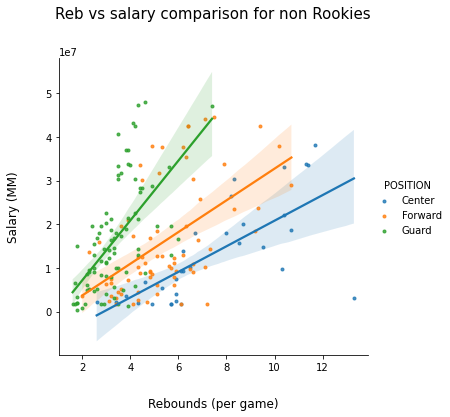

In [54]:
### Complete in this cell: non rookie contracts
#calculate non rookie stats
non_rookie_mask = (working_df.SEASON_EXP > 4)
non_rookie_df = working_df[non_rookie_mask]

#create plot1
pts_sal_non_rookie = sns.lmplot(data=non_rookie_df,x="PTS", y="SALARY",hue="POSITION", markers=".")

#set plot title and axis labels
plt.title("PPG vs salary comparison for non Rookies", fontsize=15,pad=40)
plt.xlabel('PTS (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)

#create plot2
ast_sal_non_rookie = sns.lmplot(data=non_rookie_df,x="AST", y="SALARY",hue="POSITION", markers=".")

#set plot title and axis labels
plt.title("AST vs salary comparison for non Rookies", fontsize=15,pad=40)
plt.xlabel('Assists (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)

#create plot3
reb_sal_non_rookie = sns.lmplot(data=non_rookie_df,x="REB", y="SALARY",hue="POSITION", markers=".")

#set plot title and axis labels
plt.title("Reb vs salary comparison for non Rookies", fontsize=15,pad=40)
plt.xlabel('Rebounds (per game)', fontsize=12,labelpad=25)
plt.ylabel('Salary (MM)', fontsize=12, labelpad=25)

5- Plot the scoring average grouped by position, we want to be able to see median, quartiles, etc 

Text(0, 0.5, 'Points (per game)')

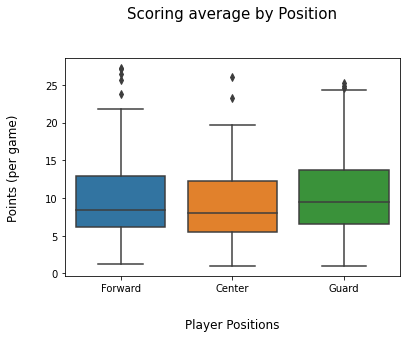

In [55]:
### Complete in this cell: Scoring average grouped by position
scor_av_position = sns.boxplot(data= working_df ,x="POSITION", y="PTS")
sns.set_theme(style='white')

#change size of figure
sns.set(rc = {'figure.figsize':(9,6)})
sns.color_palette("mako")

#set plot title and axis labels
plt.title("Scoring average by Position", fontsize=15,pad=40)
plt.xlabel('Player Positions', fontsize=12,labelpad=25)
plt.ylabel('Points (per game)', fontsize=12, labelpad=25)

6- Plot the Height distribution of all players

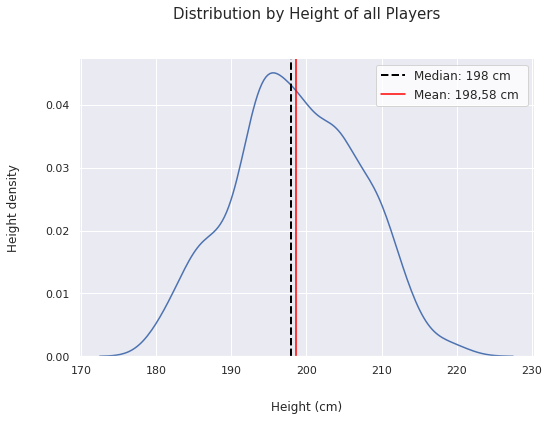

In [56]:
# create seaborn displot
height_dist=sns.displot(data=working_df, x="HEIGHT", kind="kde",height=5, aspect=1.5)
sns.set_theme(style='white')

#set plot title and axis labels
plt.title("Distribution by Height of all Players", fontsize=15,pad=40)
plt.xlabel('Height (cm)', fontsize=12,labelpad=25)
plt.ylabel('Height density', fontsize=12, labelpad=25)

# matplotlib to add axis x vertical line
plt.axvline(x=working_df["HEIGHT"].median(),color='black',ls='--', lw=2, label ="Median: 198 cm")
plt.axvline(x=working_df["HEIGHT"].mean(),color='red',ls='-', lw=1.5,label ="Mean: 198,58 cm ")

#add labels from axis x vertical line to facetgrid 
plt.legend(fontsize=12)

OPTIONAL: Can you find a way to draw a world map and show how many active players per country the NBA has? [Example](https://i.redd.it/8qymui9fnin71.jpg)

In [57]:
!pip install geopandas
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 244 kB/s 
     |████████████████████████████████| 6.3 MB 44.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1.0, 'Number of active NBA players per country')

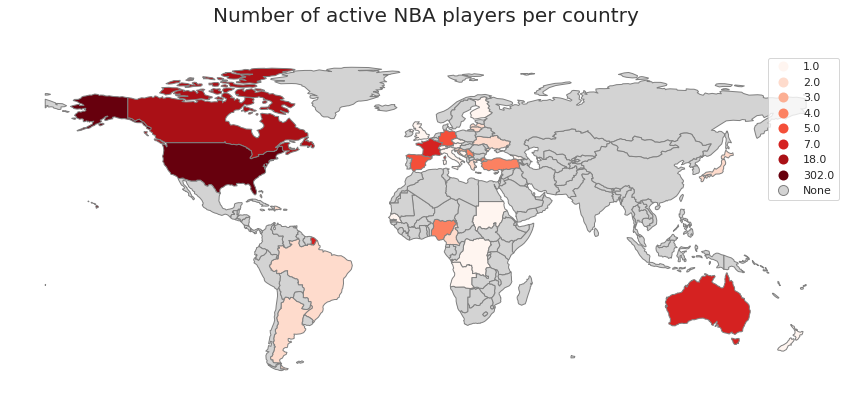

In [59]:
#loading dataset about countries to get geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#rename column 'name' to 'COUNTRY'
world.rename(columns={'name':'COUNTRY_MERGE'},inplace=True)

#create a dataframe to merge 'COUNTRY' series with dataset
player_country= pd.DataFrame(working_df.groupby('COUNTRY')['PLAYER_ID'].count())

#copy index to a column to work with
player_country['COUNTRY_MERGE']= player_country.index

#normalize dataframe data with geopandas dataset
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("USA", "United States of America")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("Bosnia and Herzegovina", "Bosnia and Herz.")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("Dominican Republic", "Dominican Rep.")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("Czech Republic", "Czechia")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("Republic of the Congo", "Dem. Rep. Congo")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("South Sudan", "S.Sudan")
player_country['COUNTRY_MERGE'] = player_country['COUNTRY_MERGE'].str.replace("DRC", "Dem. Rep. Congo")

#merge created dataframe with geopandas dataset to get geometry by normalized country, select outer to consider all labels
world= pd.merge(world, player_country, on='COUNTRY_MERGE', how= 'outer')


#create choropleth map
world= world[(world.pop_est>0) & (world.COUNTRY_MERGE != 'Antarctica')]
#dimensions of figure
fig,ax = plt.subplots(1,1,figsize=(15,15))

#create customization
nba_worldmap= world.plot(ax=ax, column= 'PLAYER_ID', legend=True,categorical=True, cmap="Reds",edgecolor="grey",missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        "label": "None"})

nba_worldmap.set_axis_off()
plt.title("Number of active NBA players per country",fontsize=20,pad=30)